## Prerequisites

Import libraries

In [1]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
from utils import resamp1d, plot_omc_vs_imu

Custom functions

In [2]:
def get_features(df_data, df_channels, tracked_points=[], incl_magn=False):
    # Select only features from tracked points
    col_tracked_pts = df_channels.loc[df_channels['tracked_point'].isin(tracked_points)]['name'].values
    df_init = df_data[col_tracked_pts]

    # Include magnetometer data or not
    if incl_magn is True:
        return df_init
    else:
        col_names = [col_name for col_name in df_init.columns if "MAGN" not in col_name]
        return df_init[col_names]

def get_targets(df_events, event_type=""):
    indx = df_events[(df_events['event_type']==event_type)]['onset'].values - 1
    return indx

## Main processing

In [3]:
# Set base directory
base_dir = "/home/robbin/Projects/annotate_gait_events/data/rawdata" if (sys.platform=="linux") else "E:\\Data"

# Get list of subject ids
sub_ids = [sub_id for sub_id in os.listdir(base_dir) if sub_id.startswith("sub-pp")]

In [4]:
# Loop over the subjects ids
for (i_sub_id, sub_id) in enumerate(sub_ids[:1]):
           
    # Get a list of OMC filenames (stereophotogrammetry)
    omc_filenames = [filename for filename in os.listdir(os.path.join(base_dir, sub_id, "motion")) if filename.endswith("_tracksys-omc_motion.tsv")]

    # Loop over the OMC filenames
    for (i_omc_filename, omc_filename) in enumerate(omc_filenames[1:2]):

        # Set the events filename (e.g. initial and final contacts)
        events_filename = omc_filename.replace("_tracksys-omc_motion.tsv", "_events.tsv")

        # Set the IMU filename
        imu_filename = omc_filename.replace("_tracksys-omc", "_tracksys-imu")

        # 
        print(f"OMC filename: {omc_filename:s}")
        print(f"IMU filename: {imu_filename:s}")
        print(f"Gait events: {events_filename:s}")

        # Load the OMC channels information 
        df_omc = pd.read_csv(os.path.join(base_dir, sub_id, "motion", omc_filename), sep="\t", header=0)
        df_omc_channels = pd.read_csv(os.path.join(base_dir, sub_id, "motion", omc_filename.replace("_motion.tsv", "_channels.tsv")), sep="\t", header=0)
        df_imu = pd.read_csv(os.path.join(base_dir, sub_id, "motion", imu_filename), sep="\t", header=0)
        df_imu_channels = pd.read_csv(os.path.join(base_dir, sub_id, "motion", imu_filename.replace("_motion.tsv", "_channels.tsv")), sep="\t", header=0)
        df_events = pd.read_csv(os.path.join(base_dir, sub_id, "motion", events_filename), sep="\t", header=0)
    
        # Get the sampling frequencies
        fs_omc = df_omc_channels["sampling_frequency"].iloc[0]
        fs_imu = df_imu_channels["sampling_frequency"].iloc[0]

        # If sampling frequencies do not match
        if fs_imu != fs_omc:
            X = df_imu.to_numpy()
            Y = resamp1d(X, fs_imu, fs_omc)
            df_imu = pd.DataFrame(data=Y, columns=df_imu.columns)
            if len(df_imu) < len(df_omc):
                df_omc = df_omc.iloc[:len(df_imu)]
            elif len(df_omc) < len(df_imu):
                df_imu = df_imu.iloc[:len(df_omc)]
            del X, Y
        
        

OMC filename: sub-pp106_task-walkSlow_tracksys-omc_motion.tsv
IMU filename: sub-pp106_task-walkSlow_tracksys-imu_motion.tsv
Gait events: sub-pp106_task-walkSlow_events.tsv


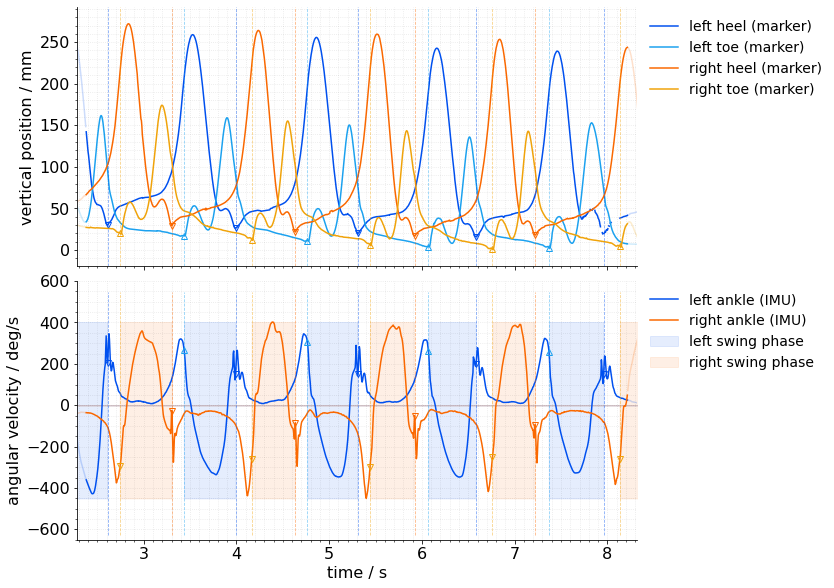

In [6]:
f = plot_omc_vs_imu(df_omc, df_omc_channels, df_imu, df_imu_channels, df_events, fname="")

In [85]:
features = get_features(df_imu, df_imu_channels, tracked_points=['left_ankle', 'right_ankle'], incl_magn=False)
targets = {'ICL': get_targets(df_events, event_type='initial_contact_left'),
           'FCL': get_targets(df_events, event_type='final_contact_left'),
           'ICR': get_targets(df_events, event_type='initial_contact_right'),
           'FCR': get_targets(df_events, event_type='final_contact_right')}

In [86]:
targets_vect = {'L': np.zeros((len(df_imu),)),
                'R': np.zeros((len(df_imu),))}

if targets['FCL'][0] < targets['ICL'][0]:
    arr = targets['ICL'] - targets['FCL'][:len(targets['ICL'])]
    for i in range(len(arr)):
        targets_vect['L'][targets['FCL'][i]:targets['ICL'][i]] = 1.0
else:
    arr = targets['ICL'][1:] - targets['FCL'][1:len(targets['ICL'][1:])]
    for i in range(len(arr)):
        targets_vect['L'][targets['FCL'][i]:targets['ICL'][1+i]] = 1.0
    targets_vect['L'][:targets['ICL'][0]] = 1.0

if targets['FCR'][0] < targets['ICR'][0]:
    arr = targets['ICR'] - targets['FCR'][:len(targets['ICR'])]
    for i in range(len(arr)):
        targets_vect['R'][targets['FCR'][i]:targets['ICR'][i]] = 1.0
else:
    arr = targets['ICR'][1:] - targets['FCR'][1:len(targets['ICR'][1:])]
    for i in range(len(arr)):
        targets_vect['R'][targets['FCR'][i]:targets['ICR'][1+i]] = 1.0
    targets_vect['R'][:targets['ICR'][0]] = 1.0

In [87]:
indx_start = df_events[(df_events["event_type"]=="start")]["onset"].values[0]-1
indx_stop  = df_events[(df_events["event_type"]=="stop")]["onset"].values[0]

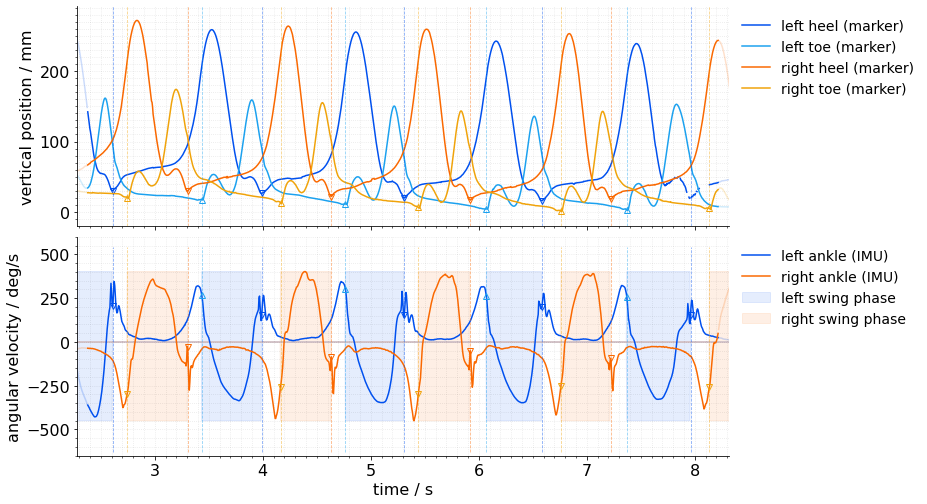

In [97]:
cm = 1/2.54
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(29.7*cm, 21*cm))

# Optical motion capture
# Left heel
axs[0].plot(np.arange(0, indx_start)/fs_omc, df_omc['l_heel_POS_z'].iloc[:indx_start], c=(0.000, 0.314, 0.937, 0.2))
axs[0].plot(np.arange(indx_start, indx_stop)/fs_omc, df_omc['l_heel_POS_z'].iloc[indx_start:indx_stop], c=(0.000, 0.314, 0.937), label='left heel (marker)')
axs[0].plot(np.arange(indx_stop, len(df_omc))/fs_omc, df_omc['l_heel_POS_z'].iloc[indx_stop:], c=(0.000, 0.314, 0.937, 0.2))
axs[0].plot(targets['ICL']/fs_omc, df_omc['l_heel_POS_z'].iloc[targets['ICL']], ls='none', marker='v', mfc='none', mec=(0.000, 0.314, 0.937))

# Left toe
axs[0].plot(np.arange(0, indx_start)/fs_omc, df_omc['l_toe_POS_z'].iloc[:indx_start], c=(0.106, 0.631, 0.937, 0.2))
axs[0].plot(np.arange(indx_start, indx_stop)/fs_omc, df_omc['l_toe_POS_z'].iloc[indx_start:indx_stop], c=(0.106, 0.631, 0.937), label='left toe (marker)')
axs[0].plot(np.arange(indx_stop, len(df_omc))/fs_omc, df_omc['l_toe_POS_z'].iloc[indx_stop:], c=(0.106, 0.631, 0.937, 0.2))
axs[0].plot(targets['FCL']/fs_omc, df_omc['l_toe_POS_z'].iloc[targets['FCL']], ls='none', marker='^', mfc='none', mec=(0.106, 0.631, 0.937))

# Right heel
axs[0].plot(np.arange(0, indx_start)/fs_omc, df_omc['r_heel_POS_z'].iloc[:indx_start], c=(0.980, 0.408, 0.000, 0.2))
axs[0].plot(np.arange(indx_start, indx_stop)/fs_omc, df_omc['r_heel_POS_z'].iloc[indx_start:indx_stop], c=(0.980, 0.408, 0.000), label='right heel (marker)')
axs[0].plot(np.arange(indx_stop, len(df_omc))/fs_omc, df_omc['r_heel_POS_z'].iloc[indx_stop:], c=(0.980, 0.408, 0.000, 0.2))
axs[0].plot(targets['ICR']/fs_omc, df_omc['r_heel_POS_z'].iloc[targets['ICR']], ls='none', marker='v', mfc='none', mec=(0.980, 0.408, 0.000))

# Right heel
axs[0].plot(np.arange(0, indx_start)/fs_omc, df_omc['r_toe_POS_z'].iloc[:indx_start], c=(0.941, 0.639, 0.039, 0.2))
axs[0].plot(np.arange(indx_start, indx_stop)/fs_omc, df_omc['r_toe_POS_z'].iloc[indx_start:indx_stop], c=(0.941, 0.639, 0.039), label='right toe (marker)')
axs[0].plot(np.arange(indx_stop, len(df_omc))/fs_omc, df_omc['r_toe_POS_z'].iloc[indx_stop:], c=(0.941, 0.639, 0.039, 0.2))
axs[0].plot(targets['FCR']/fs_omc, df_omc['r_toe_POS_z'].iloc[targets['FCR']], ls='none', marker='^', mfc='none', mec=(0.941, 0.639, 0.039))

# Styling
axs[0].spines['right'].set_color('none')
axs[0].spines['top'].set_color('none')
axs[0].set_ylim((df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].min().min()-20, df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].max().max()+20))
axs[0].set_ylabel('vertical position / mm', fontsize=16)
axs[0].yaxis.set_minor_locator(plt.MultipleLocator(10))
axs[0].grid(which='both', ls=':', c=(0, 0, 0), alpha=0.1)
axs[0].tick_params(axis='both', labelsize=16)
axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False, fontsize=14)

# Inertial measurement unit
# Left 
axs[1].plot(np.arange(0, indx_start)/fs_imu, features['left_ankle_ANGVEL_z'].iloc[:indx_start], c=(0.000, 0.314, 0.937, 0.2))
axs[1].plot(np.arange(indx_start, indx_stop)/fs_imu, features['left_ankle_ANGVEL_z'].iloc[indx_start:indx_stop], c=(0.000, 0.314, 0.937), label='left ankle (IMU)')
axs[1].plot(np.arange(indx_stop, len(df_imu))/fs_imu, features['left_ankle_ANGVEL_z'].iloc[indx_stop:], c=(0.000, 0.314, 0.937, 0.2))
axs[1].plot(targets['ICL']/fs_imu, features['left_ankle_ANGVEL_z'].iloc[targets['ICL']], ls='none', marker='v', mfc='none', mec=(0.000, 0.314, 0.937))
axs[1].plot(targets['FCL']/fs_imu, features['left_ankle_ANGVEL_z'].iloc[targets['FCL']], ls='none', marker='^', mfc='none', mec=(0.106, 0.631, 0.937))

# Right 
axs[1].plot(np.arange(0, indx_start)/fs_imu, features['right_ankle_ANGVEL_z'].iloc[:indx_start], c=(0.980, 0.408, 0.000, 0.2))
axs[1].plot(np.arange(indx_start, indx_stop)/fs_imu, features['right_ankle_ANGVEL_z'].iloc[indx_start:indx_stop], c=(0.980, 0.408, 0.000), label='right ankle (IMU)')
axs[1].plot(np.arange(indx_stop, len(df_imu))/fs_imu, features['right_ankle_ANGVEL_z'].iloc[indx_stop:], c=(0.980, 0.408, 0.000, 0.2))
axs[1].plot(targets['ICR']/fs_omc, features['right_ankle_ANGVEL_z'].iloc[targets['ICR']], ls='none', marker='v', mfc='none', mec=(0.980, 0.408, 0.000))
axs[1].plot(targets['FCR']/fs_omc, features['right_ankle_ANGVEL_z'].iloc[targets['FCR']], ls='none', marker='v', mfc='none', mec=(0.941, 0.639, 0.039))

# Styling
axs[1].spines['right'].set_color('none')
axs[1].spines['top'].set_color('none')
axs[1].set_ylim((features[['left_ankle_ANGVEL_z', 'right_ankle_ANGVEL_z']].min().min()-200, features[['left_ankle_ANGVEL_z', 'right_ankle_ANGVEL_z']].max().max()+200))
axs[1].set_xlim((indx_start-20, indx_stop+20)/fs_imu)
axs[1].set_xlabel('time / s', fontsize=16)
axs[1].set_ylabel('angular velocity / deg/s', fontsize=16)
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(0.1))
axs[1].yaxis.set_minor_locator(plt.MultipleLocator(50))
axs[1].grid(which='both', ls=':', c=(0, 0, 0), alpha=0.1)
axs[1].tick_params(axis='both', labelsize=16)


# Plot vertical lines for events
for i in range(len(targets['ICL'])):
    axs[0].plot([targets['ICL'][i], targets['ICL'][i]]/fs_omc, [df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].min().min()-20, df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].max().max()+20], ls='--', c=(0.000, 0.314, 0.937, 0.5), lw=0.8)
    axs[1].plot([targets['ICL'][i], targets['ICL'][i]]/fs_imu, [features[['left_ankle_ANGVEL_z', 'left_ankle_ANGVEL_z']].min().min()-200, features[['left_ankle_ANGVEL_z', 'left_ankle_ANGVEL_z']].max().max()+200], ls='--', c=(0.000, 0.314, 0.937, 0.5), lw=0.8)

for i in range(len(targets['FCL'])):
    axs[0].plot([targets['FCL'][i], targets['FCL'][i]]/fs_omc, [df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].min().min()-20, df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].max().max()+20], ls='--', c=(0.106, 0.631, 0.937, 0.5), lw=0.8)
    axs[1].plot([targets['FCL'][i], targets['FCL'][i]]/fs_imu, [features[['left_ankle_ANGVEL_z', 'left_ankle_ANGVEL_z']].min().min()-200, features[['left_ankle_ANGVEL_z', 'left_ankle_ANGVEL_z']].max().max()+200], ls='--', c=(0.106, 0.631, 0.937, 0.5), lw=0.8)
    
for i in range(len(targets['ICR'])):
    axs[0].plot([targets['ICR'][i], targets['ICR'][i]]/fs_omc, [df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].min().min()-20, df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].max().max()+20], ls='--', c=(0.980, 0.408, 0.000, 0.5), lw=0.8)
    axs[1].plot([targets['ICR'][i], targets['ICR'][i]]/fs_imu, [features[['left_ankle_ANGVEL_z', 'left_ankle_ANGVEL_z']].min().min()-200, features[['left_ankle_ANGVEL_z', 'left_ankle_ANGVEL_z']].max().max()+200], ls='--', c=(0.980, 0.408, 0.000, 0.5), lw=0.8)
    
for i in range(len(targets['FCR'])):
    axs[0].plot([targets['FCR'][i], targets['FCR'][i]]/fs_omc, [df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].min().min()-20, df_omc[['l_heel_POS_z', 'l_toe_POS_z', 'r_heel_POS_z', 'r_toe_POS_z']].max().max()+20], ls='--', c=(0.941, 0.639, 0.039, 0.5), lw=0.8)
    axs[1].plot([targets['FCR'][i], targets['FCR'][i]]/fs_imu, [features[['left_ankle_ANGVEL_z', 'left_ankle_ANGVEL_z']].min().min()-200, features[['left_ankle_ANGVEL_z', 'left_ankle_ANGVEL_z']].max().max()+200], ls='--', c=(0.941, 0.639, 0.039, 0.5), lw=0.8)

# Plot gait cycle swing phase
axs[1].fill_between(np.arange(len(targets_vect['L']))/fs_imu, targets_vect['L']*features[['left_ankle_ANGVEL_z', 'right_ankle_ANGVEL_z']].max().max(), color=(0.000, 0.314, 0.937), alpha=0.1, label='left swing phase')
axs[1].fill_between(np.arange(len(targets_vect['L']))/fs_imu, targets_vect['L']*features[['left_ankle_ANGVEL_z', 'right_ankle_ANGVEL_z']].min().min(), color=(0.000, 0.314, 0.937), alpha=0.1)
axs[1].fill_between(np.arange(len(targets_vect['R']))/fs_imu, targets_vect['R']*features[['left_ankle_ANGVEL_z', 'right_ankle_ANGVEL_z']].max().max(), color=(0.980, 0.408, 0.000), alpha=0.1, label='right swing phase')
axs[1].fill_between(np.arange(len(targets_vect['R']))/fs_imu, targets_vect['R']*features[['left_ankle_ANGVEL_z', 'right_ankle_ANGVEL_z']].min().min(), color=(0.980, 0.408, 0.000), alpha=0.1)
axs[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False, fontsize=14)

plt.subplots_adjust(hspace=0.05)
# 
# plt.savefig(os.path.join("/home/robbin/Desktop/fig", omc_filename.replace("_tracksys-omc_motion.tsv", ".png")), dpi=300, format='png', transparent=True)
plt.savefig(os.path.join("/home/robbin/Desktop/fig", omc_filename.replace("_tracksys-omc_motion.tsv", ".pdf")), dpi=300, format='pdf', transparent=True, bbox_inches='tight')

In [ ]:
print(axs[1].xaxis.get_major_locator())
print(axs[1].xaxis.get_minor_locator())

In [28]:
np.arange(6.25, 8.75, 0.25)

array([6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  , 8.25, 8.5 ])